### User-base Collaborative Filtering - Testing
This notebook is used to simulate the performance of the user-based collaborative filtering algorithm in a retrieval setting and in a prediction setting. 

* In the retrievak stage, it is modified to filter out low-similarity users and supplement the similar user list with users from the same cluster 

#### Pre-requisites
- The model is trained and the index is created in the notebook `UserCF Model & Index.ipynb`.
- The index is saved in the file `yelp_UserCF.db` in the same directory as this notebook.

In [1]:
# Import utilities and dependencies
import sys
sys.path.append('../')
from utilities import *
import sqlite3
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import os
import openpyxl as py
import matplotlib.pyplot as plt

In [2]:
# Load Yelp data
db_folder = '../../data/processed_data/yelp_data/'
data_files = ['business', 'categories', 'review']
yelp_data = load_data_from_db(db_folder, data_files)
for table, df in yelp_data.items():
    print(f"Loaded {len(df)} rows from {table} table.")

Loaded 78059 rows from business table.
Loaded 360656 rows from categories table.
Loaded 980418 rows from review table.


In [3]:
# Prepare data
df_business = yelp_data["business"]
df_review = yelp_data["review"]
user_mapping, business_mapping, user_business = get_user_business(df_business, df_review)

In [4]:
# Split into train (80%) and test (20%)
train_data, test_data = train_test_split(user_business, test_size=0.2, random_state=42)

In [5]:
# Balance test data (50% positive)
test_data = balance_test_data(test_data)
test_data_grouped = test_data.groupby('user_id')['business_id'].apply(list).reset_index()

Number of positive reviews: 136473
Number of negative reviews: 59624
Total number of reviews: 197147
Ratio of positive to negative reviews: 2.29
Number of positive reviews: 59624
Number of negative reviews: 59624
Total number of reviews: 119248
Ratio of positive to negative reviews: 1.00


# Retrieval

In [29]:
# Load cluster data from Excel with error handling
cluster_file = 'clustered_users.xlsx'  # Adjust path as needed
cluster_df = pd.read_excel(cluster_file)
user_to_cluster = dict(zip(cluster_df['user_id'], cluster_df['cluster']))

In [30]:
# Connect to UserCF database
db_path = './yelp_UserCF.db'  # Using cosine similarity-based DB
conn = sqlite3.connect(db_path)

In [31]:
# Retrieve user mapping from database
def retrieve_user_mapping(conn):
    cursor = conn.cursor()
    cursor.execute('''SELECT user_id, user_idx FROM user_mapping''')
    user_mapping = {row[0]: row[1] for row in cursor.fetchall()}
    return user_mapping

# Get businesses rated by a user
def get_user_businesses(user_id, conn):
    cursor = conn.cursor()
    cursor.execute('''SELECT business_id, stars_review FROM user_item_index WHERE user_id = ?''', (user_id,))
    return cursor.fetchall()

# Get top-k similar users with cluster supplementation
def get_top_k_similar_users_with_clusters(user_id, user_mapping, user_to_cluster, similarity_threshold, k, conn):
    # Get initial similar users from cosine similarity
    cursor = conn.cursor()
    cursor.execute('''SELECT similarity_vector FROM user_user_similarity WHERE user_id = ?''', (user_id,))
    result = cursor.fetchone()
    if result is None:
        similar_users = []
    else:
        similarity_vector = pickle.loads(result[0])
        indices, data = similarity_vector
        idx_to_user = {v: k for k, v in user_mapping.items()}
        similar_users = [(idx_to_user.get(idx, "Unknown"), score) for idx, score in zip(indices, data) if score >= similarity_threshold]
        similar_users = sorted(similar_users, key=lambda x: -x[1])[:k]  # Filter and sort by similarity
    
    # Handle users with no similar users or supplement if fewer than k
    current_count = len([u for u, s in similar_users if u != "Unknown"])
    if user_id in user_to_cluster:  # Only proceed if user is in cluster data
        target_cluster = user_to_cluster[user_id]
        cluster_users = cluster_df[cluster_df['cluster'] == target_cluster]['user_id'].tolist()
        # Remove target user and already included users
        cluster_users = [u for u in cluster_users if u != user_id and u not in [su[0] for su in similar_users]]
        
        if current_count == 0:  # No similar users case
            # Use cluster users as similar users (no similarity score needed)
            similar_users = [(u, 0) for u in cluster_users if u in user_mapping][:k]
        elif current_count < k:  # Supplement case
            # Add cluster users up to k (no similarity score needed)
            needed = k - current_count
            additional_users = [(u, 0) for u in cluster_users[:needed] if u in user_mapping]
            similar_users.extend(additional_users)
    
    return similar_users[:k]  # Ensure exactly k users

# Predict user interests for recommendation
def predict_user_interests_usercf(user_id, user_mapping, user_to_cluster, similarity_threshold, conn, k=300):
    similar_users = get_top_k_similar_users_with_clusters(user_id, user_mapping, user_to_cluster, similarity_threshold, k, conn)
    recommended_businesses = {}
    for similar_user_id, _ in similar_users:
        if similar_user_id == "Unknown":
            continue
        similar_user_businesses = get_user_businesses(similar_user_id, conn)
        for business_id, score in similar_user_businesses:
            if business_id in recommended_businesses:
                recommended_businesses[business_id] += score
            else:
                recommended_businesses[business_id] = score
    recommended_businesses = sorted(recommended_businesses.items(), key=lambda x: -x[1])
    return recommended_businesses[:k]

# Simulate recommendations for test users
def simulate_recommendations_usercf(test_data_grouped, user_mapping, user_to_cluster, similarity_threshold, conn, k=300, num_users=1000):
    recommendations = {}
    for i, user_id in enumerate(test_data_grouped['user_id']):
        if i >= num_users:
            break
        recommendation = predict_user_interests_usercf(user_id, user_mapping, user_to_cluster, similarity_threshold, conn, k)
        business_ids, scores = zip(*recommendation) if recommendation else ([], [])
        recommendations[user_id] = (list(business_ids), list(scores))
    return recommendations

In [47]:
# Evaluate retrieval
user_mapping = retrieve_user_mapping(conn)
similarity_threshold = 0
retrieval_recommendations = simulate_recommendations_usercf3(test_data_grouped, user_mapping, user_to_cluster, conn, k=300, num_users=1000)
true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks = check_retrieval_recommendations(retrieval_recommendations, test_data, test_data_grouped)
evaluation_metric, confusion_matrix, background_stats = compute_evaluation_metric(true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks)

In [48]:
print("Testing Data Statistics")
display(background_stats)
print("Retrieval Evaluation Metrics")
display(evaluation_metric)
print("Retrieval Confusion Matrix")
display(confusion_matrix)

Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,1045,1083,2128,0.491071


Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5381,0.561,0.2727,0.367,0.304,0.0627


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


In [34]:
# Evaluate retrieval
user_mapping = retrieve_user_mapping(conn)
similarity_threshold = 0
retrieval_recommendations = simulate_recommendations_usercf(test_data_grouped, user_mapping, user_to_cluster, similarity_threshold, conn, k=300, num_users=1000)
true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks = check_retrieval_recommendations(retrieval_recommendations, test_data, test_data_grouped)
evaluation_metric, confusion_matrix, background_stats = compute_evaluation_metric(true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks)

In [35]:
print("Testing Data Statistics")
display(background_stats)
print("Retrieval Evaluation Metrics")
display(evaluation_metric)
print("Retrieval Confusion Matrix")
display(confusion_matrix)

Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,1045,1083,2128,0.491071


Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5381,0.561,0.2727,0.367,0.304,0.0627


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


# Tuning parameter

## Tuning parameter k: k = 500

In [32]:
def get_top_k_similar_users_no_threshold(user_id, user_mapping, user_to_cluster, k, conn):
    cursor = conn.cursor()
    cursor.execute('''SELECT similarity_vector FROM user_user_similarity WHERE user_id = ?''', (user_id,))
    result = cursor.fetchone()
    
    idx_to_user = {v: k for k, v in user_mapping.items()}
    if result is None:
        similar_users = []
    else:
        similarity_vector = pickle.loads(result[0])
        indices, data = similarity_vector
        # Take all valid users, no threshold filtering
        similar_users = [(idx_to_user.get(idx, "Unknown"), score) for idx, score in zip(indices, data)]
        similar_users = sorted(similar_users, key=lambda x: -x[1])  # Sort by similarity
    
    valid_sim_users = [(u, s) for u, s in similar_users if u != "Unknown"]
    num_similar = len(valid_sim_users)
    
    if num_similar >= k:
        # Take top k from similarity vector
        return valid_sim_users[:k]
    else:
        # Supplement with cluster users
        if user_id not in user_to_cluster:
            return valid_sim_users[:k]  # Return what we have if no cluster data
        target_cluster = user_to_cluster[user_id]
        cluster_users = cluster_df[cluster_df['cluster'] == target_cluster]['user_id'].tolist()
        cluster_users = [u for u in cluster_users if u != user_id and u not in [su[0] for su in valid_sim_users]]
        
        # Add cluster users to reach k
        needed = k - num_similar
        additional_users = [(u, 0) for u in cluster_users[:needed] if u in user_mapping]
        return valid_sim_users + additional_users[:k - num_similar]  # Ensure exactly k
    
    # Predict user interests for recommendation
def predict_user_interests_usercf3(user_id, user_mapping, user_to_cluster, conn, k=300):
    similar_users = get_top_k_similar_users_no_threshold(user_id, user_mapping, user_to_cluster, k, conn)
    recommended_businesses = {}
    for similar_user_id, _ in similar_users:
        if similar_user_id == "Unknown":
            continue
        similar_user_businesses = get_user_businesses(similar_user_id, conn)
        for business_id, score in similar_user_businesses:
            if business_id in recommended_businesses:
                recommended_businesses[business_id] += score
            else:
                recommended_businesses[business_id] = score
    recommended_businesses = sorted(recommended_businesses.items(), key=lambda x: -x[1])
    return recommended_businesses[:k]

# Simulate recommendations for test users
def simulate_recommendations_usercf3(test_data_grouped, user_mapping, user_to_cluster, conn, k=300, num_users=1000):
    recommendations = {}
    for i, user_id in enumerate(test_data_grouped['user_id']):
        if i >= num_users:
            break
        recommendation = predict_user_interests_usercf3(user_id, user_mapping, user_to_cluster, conn, k)
        business_ids, scores = zip(*recommendation) if recommendation else ([], [])
        recommendations[user_id] = (list(business_ids), list(scores))
    return recommendations

In [55]:
# Evaluate retrieval
user_mapping = retrieve_user_mapping(conn)
similarity_threshold = 0
retrieval_recommendations = simulate_recommendations_usercf3(test_data_grouped, user_mapping, user_to_cluster, conn, k=500, num_users=1000)
true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks = check_retrieval_recommendations(retrieval_recommendations, test_data, test_data_grouped)
evaluation_metric, confusion_matrix, background_stats = compute_evaluation_metric(true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks)

In [56]:
print("Testing Data Statistics")
display(background_stats)
print("Retrieval Evaluation Metrics")
display(evaluation_metric)
print("Retrieval Confusion Matrix")
display(confusion_matrix)

Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,1045,1083,2128,0.491071


Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5437,0.5595,0.333,0.4175,0.3623,0.0519


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,348,809,274,697


## Separate k to k_users and k_items and Tune them

In [33]:
def get_top_k_similar_users_no_threshold(user_id, user_mapping, user_to_cluster, k_users, conn):
    cursor = conn.cursor()
    cursor.execute('''SELECT similarity_vector FROM user_user_similarity WHERE user_id = ?''', (user_id,))
    result = cursor.fetchone()
    
    idx_to_user = {v: k for k, v in user_mapping.items()}
    if result is None:
        similar_users = []
    else:
        similarity_vector = pickle.loads(result[0])
        indices, data = similarity_vector
        # Take all valid users, no threshold filtering
        similar_users = [(idx_to_user.get(idx, "Unknown"), score) for idx, score in zip(indices, data)]
        similar_users = sorted(similar_users, key=lambda x: -x[1])  # Sort by similarity
    
    valid_sim_users = [(u, s) for u, s in similar_users if u != "Unknown"]
    num_similar = len(valid_sim_users)
    
    if num_similar >= k_users:
        # Take top k_users from similarity vector
        return valid_sim_users[:k_users]
    else:
        # Supplement with cluster users
        if user_id not in user_to_cluster:
            return valid_sim_users[:k_users]  # Return what we have if no cluster data
        target_cluster = user_to_cluster[user_id]
        cluster_users = cluster_df[cluster_df['cluster'] == target_cluster]['user_id'].tolist()
        cluster_users = [u for u in cluster_users if u != user_id and u not in [su[0] for su in valid_sim_users]]
        
        # Add cluster users to reach k_users
        needed = k_users - num_similar
        additional_users = [(u, 0) for u in cluster_users[:needed] if u in user_mapping]
        return valid_sim_users + additional_users[:k_users - num_similar]  # Ensure exactly k_users

def predict_user_interests_usercf_traink(user_id, user_mapping, user_to_cluster, conn, k_users=300, k_items=300):
    similar_users = get_top_k_similar_users_no_threshold(user_id, user_mapping, user_to_cluster, k_users, conn)
    recommended_businesses = {}
    for similar_user_id, _ in similar_users:
        if similar_user_id == "Unknown":
            continue
        similar_user_businesses = get_user_businesses(similar_user_id, conn)
        for business_id, score in similar_user_businesses:
            if business_id in recommended_businesses:
                recommended_businesses[business_id] += score
            else:
                recommended_businesses[business_id] = score
    recommended_businesses = sorted(recommended_businesses.items(), key=lambda x: -x[1])
    return recommended_businesses[:k_items]

def simulate_recommendations_usercf_traink(test_data_grouped, user_mapping, user_to_cluster, conn, k_users=300, k_items=300, num_users=1000):
    recommendations = {}
    for i, user_id in enumerate(test_data_grouped['user_id']):
        if i >= num_users:
            break
        recommendation = predict_user_interests_usercf_traink(user_id, user_mapping, user_to_cluster, conn, k_users, k_items)
        business_ids, scores = zip(*recommendation) if recommendation else ([], [])
        recommendations[user_id] = (list(business_ids), list(scores))
    return recommendations

In [26]:
def compute_recall(recommendations, test_data_grouped):
    true_positives = 0
    total_positives = 0
    for user_id, (rec_businesses, _) in recommendations.items():
        user_row = test_data_grouped[test_data_grouped['user_id'] == user_id]
        if len(user_row) == 0:
            continue
        actual_businesses = set(user_row['business_id'].iloc[0]) if isinstance(user_row['business_id'].iloc[0], list) else set([user_row['business_id'].iloc[0]])
        total_positives += len(actual_businesses)
        true_positives += len(set(rec_businesses) & actual_businesses)
    return true_positives / total_positives if total_positives > 0 else 0

def train_k_parameters(test_data_grouped, user_mapping, user_to_cluster, conn, num_users=1000):
    k_values = [x for x in range(300, 501, 50)]  # [100, 150, 200, 250, 300, 350]
    recall_results = {}
    
    for k_users in k_values:
        for k_items in k_values:
            print(f"Testing k_users={k_users}, k_items={k_items}")
            recommendations = simulate_recommendations_usercf_traink(
                test_data_grouped, user_mapping, user_to_cluster, conn, 
                k_users=k_users, k_items=k_items, num_users=num_users
            )
            recall = compute_recall(recommendations, test_data_grouped)
            recall_results[(k_users, k_items)] = recall
    
    recall_df = pd.DataFrame(index=k_values, columns=k_values)
    for (k_users, k_items), recall in recall_results.items():
        recall_df.loc[k_users, k_items] = recall
    
    print("\nRecall for Different k_users and k_items Combinations:")
    print(recall_df)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(recall_df.astype(float), annot=True, fmt=".4f", cmap="YlGnBu")
    plt.xlabel("k_items (Number of Recommended Businesses)")
    plt.ylabel("k_users (Number of Similar Users)")
    plt.title("Recall Heatmap for k_users vs. k_items")
    plt.show()
    
    best_combo = max(recall_results, key=recall_results.get)
    best_recall = recall_results[best_combo]
    print(f"\nBest combination: k_users={best_combo[0]}, k_items={best_combo[1]} with Recall={best_recall:.4f}")
    
    return recall_results, best_combo

Testing k_users=300, k_items=300
Testing k_users=300, k_items=350
Testing k_users=300, k_items=400
Testing k_users=300, k_items=450
Testing k_users=300, k_items=500
Testing k_users=350, k_items=300
Testing k_users=350, k_items=350
Testing k_users=350, k_items=400
Testing k_users=350, k_items=450
Testing k_users=350, k_items=500
Testing k_users=400, k_items=300
Testing k_users=400, k_items=350
Testing k_users=400, k_items=400
Testing k_users=400, k_items=450
Testing k_users=400, k_items=500
Testing k_users=450, k_items=300
Testing k_users=450, k_items=350
Testing k_users=450, k_items=400
Testing k_users=450, k_items=450
Testing k_users=450, k_items=500
Testing k_users=500, k_items=300
Testing k_users=500, k_items=350
Testing k_users=500, k_items=400
Testing k_users=500, k_items=450
Testing k_users=500, k_items=500

Recall for Different k_users and k_items Combinations:
          300       350       400       450       500
300  0.238701  0.254237  0.271186  0.285311  0.298493
350  0.2410

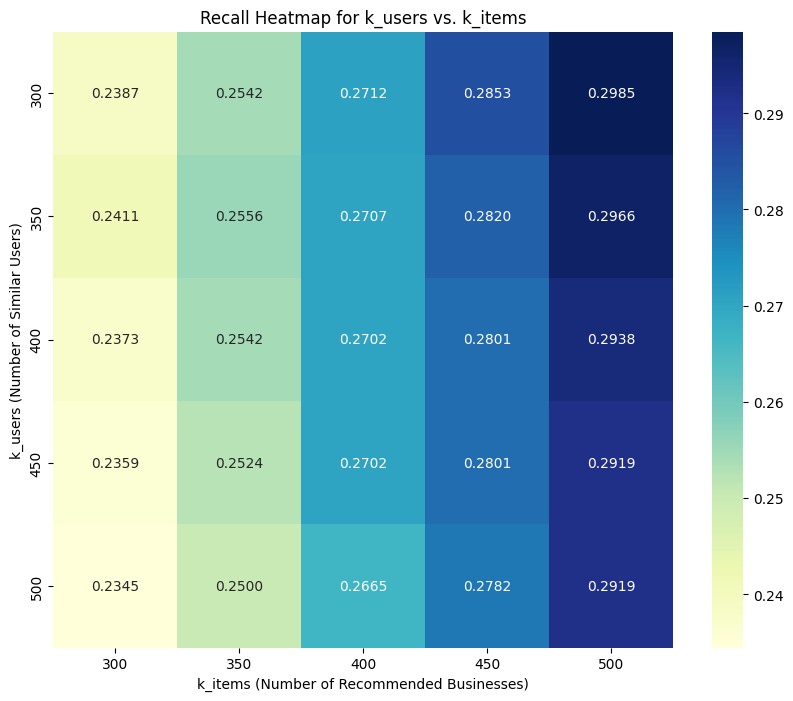


Best combination: k_users=300, k_items=500 with Recall=0.2985


In [27]:
recall_results, best_combo = train_k_parameters(test_data_grouped, user_mapping, user_to_cluster, conn, num_users=1000)
conn.close()

In [35]:
k_values = [300, 350, 400, 500, 550]
recall_results = {}

for k_users in k_values:
    for k_items in k_values:
        recommendations = simulate_recommendations_usercf_traink(
                test_data_grouped, user_mapping, user_to_cluster, conn, 
                k_users=k_users, k_items=k_items, num_users=1000)
        true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks = check_retrieval_recommendations(recommendations, test_data, test_data_grouped)
        evaluation_metric, _, _ = compute_evaluation_metric(true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks)
        recall_results[(k_users, k_items)] = evaluation_metric['Recall'].iloc[0]
        print(f"Number of similar users: {k_users}, Number of retrieved business: {k_items}")
        print("Retrieval Evaluation Metrics")
        display(evaluation_metric)
        print("Retrieval Confusion Matrix")
        display(confusion_matrix)

print(f"Recall Summary: \n {recall_results}")   

Number of similar users: 300, Number of retrieved business: 300
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5381,0.561,0.2727,0.367,0.304,0.0627


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 300, Number of retrieved business: 350
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5395,0.5601,0.29,0.3821,0.3209,0.0593


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 300, Number of retrieved business: 400
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5423,0.5615,0.31,0.3995,0.3406,0.0556


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 300, Number of retrieved business: 500
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5456,0.5613,0.3416,0.4247,0.3706,0.0514


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 300, Number of retrieved business: 550
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5437,0.5556,0.3541,0.4325,0.3818,0.0491


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 350, Number of retrieved business: 300
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5404,0.5653,0.2775,0.3723,0.309,0.0617


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 350, Number of retrieved business: 350
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5418,0.5643,0.2938,0.3864,0.3249,0.0588


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 350, Number of retrieved business: 400
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5418,0.5608,0.3091,0.3985,0.3396,0.0555


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 350, Number of retrieved business: 500
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5428,0.557,0.3368,0.4198,0.3658,0.0517


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 350, Number of retrieved business: 550
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5461,0.5598,0.3541,0.4338,0.3822,0.0492


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 400, Number of retrieved business: 300
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5395,0.5644,0.2727,0.3677,0.3042,0.0627


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 400, Number of retrieved business: 350
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5423,0.5656,0.2928,0.3859,0.3241,0.0591


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 400, Number of retrieved business: 400
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5414,0.56,0.3081,0.3975,0.3386,0.0558


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 400, Number of retrieved business: 500
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5446,0.5607,0.3359,0.4201,0.3652,0.0523


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 400, Number of retrieved business: 550
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5446,0.5579,0.3502,0.4303,0.3784,0.05


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 500, Number of retrieved business: 300
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5395,0.5651,0.2699,0.3653,0.3013,0.0622


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 500, Number of retrieved business: 350
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5418,0.5658,0.288,0.3817,0.3194,0.0594


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 500, Number of retrieved business: 400
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5432,0.5644,0.3062,0.397,0.3371,0.0558


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 500, Number of retrieved business: 500
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5437,0.5595,0.333,0.4175,0.3623,0.0519


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 500, Number of retrieved business: 550
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5437,0.5575,0.3435,0.4251,0.3721,0.05


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 550, Number of retrieved business: 300
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5395,0.5649,0.2708,0.3661,0.3023,0.0624


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 550, Number of retrieved business: 350
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5409,0.5644,0.2852,0.3789,0.3165,0.0598


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 550, Number of retrieved business: 400
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5404,0.5595,0.3014,0.3918,0.3321,0.0564


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 550, Number of retrieved business: 500
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5446,0.5611,0.334,0.4187,0.3634,0.0525


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Number of similar users: 550, Number of retrieved business: 550
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5451,0.5593,0.3474,0.4286,0.3759,0.0501


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,285,860,223,760


Recall Summary: 
 {(300, 300): np.float64(0.2727), (300, 350): np.float64(0.29), (300, 400): np.float64(0.31), (300, 500): np.float64(0.3416), (300, 550): np.float64(0.3541), (350, 300): np.float64(0.2775), (350, 350): np.float64(0.2938), (350, 400): np.float64(0.3091), (350, 500): np.float64(0.3368), (350, 550): np.float64(0.3541), (400, 300): np.float64(0.2727), (400, 350): np.float64(0.2928), (400, 400): np.float64(0.3081), (400, 500): np.float64(0.3359), (400, 550): np.float64(0.3502), (500, 300): np.float64(0.2699), (500, 350): np.float64(0.288), (500, 400): np.float64(0.3062), (500, 500): np.float64(0.333), (500, 550): np.float64(0.3435), (550, 300): np.float64(0.2708), (550, 350): np.float64(0.2852), (550, 400): np.float64(0.3014), (550, 500): np.float64(0.334), (550, 550): np.float64(0.3474)}


In [36]:
import collections

sorted_recall_results = collections.OrderedDict(recall_results)
print(sorted_recall_results)

OrderedDict([((300, 300), np.float64(0.2727)), ((300, 350), np.float64(0.29)), ((300, 400), np.float64(0.31)), ((300, 500), np.float64(0.3416)), ((300, 550), np.float64(0.3541)), ((350, 300), np.float64(0.2775)), ((350, 350), np.float64(0.2938)), ((350, 400), np.float64(0.3091)), ((350, 500), np.float64(0.3368)), ((350, 550), np.float64(0.3541)), ((400, 300), np.float64(0.2727)), ((400, 350), np.float64(0.2928)), ((400, 400), np.float64(0.3081)), ((400, 500), np.float64(0.3359)), ((400, 550), np.float64(0.3502)), ((500, 300), np.float64(0.2699)), ((500, 350), np.float64(0.288)), ((500, 400), np.float64(0.3062)), ((500, 500), np.float64(0.333)), ((500, 550), np.float64(0.3435)), ((550, 300), np.float64(0.2708)), ((550, 350), np.float64(0.2852)), ((550, 400), np.float64(0.3014)), ((550, 500), np.float64(0.334)), ((550, 550), np.float64(0.3474))])


# Test Runtime

## Test Runtime for k

In [ ]:
import time

def test_runtime_for_one_user(test_data_grouped, user_mapping, user_to_cluster, conn, k_users=300, k_items=300):
    # Select the first user from test_data_grouped (or choose any specific user)
    user_id = test_data_grouped['user_id'].iloc[0]  # You can change this to a specific user_id if desired
    print(f"Testing runtime for user: {user_id}")
    
    # Measure runtime
    start_time = time.time()
    recommended_businesses = predict_user_interests_usercf_traink(
        user_id, user_mapping, user_to_cluster, conn, k_users=k_users, k_items=k_items
    )
    end_time = time.time()
    
    # Calculate runtime
    runtime = end_time - start_time
    
    # Output results
    print(f"Runtime: {runtime:.4f} seconds")
    print(f"Number of similar users requested (k_users): {k_users}")
    print(f"Number of businesses returned (k_items): {min(k_items, len(recommended_businesses))}")
    print(f"Top 5 recommended businesses: {recommended_businesses[:5]}")
    
    
    return runtime, recommended_businesses

In [46]:
k_values = [500, 550]
for k_users in k_values:
    for k_items in k_values:
        print(f"\nTesting k_users={k_users}, k_items={k_items}")
        runtime, _ = test_runtime_for_one_user(
            test_data_grouped, user_mapping, user_to_cluster, conn, 
            k_users=k_users, k_items=k_items
        )


Testing k_users=500, k_items=500
Testing runtime for user: --4AjktZiHowEIBCMd4CZA
Runtime: 4.6854 seconds
Number of similar users requested (k_users): 500
Number of businesses returned (k_items): 500
Top 5 recommended businesses: [('eXKblEHP3YJYU1Awz08hVw', 99.0), ('vuE1iseFrgNPumUEfHIZZQ', 83.0), ('EtKSTHV5Qx_Q7Aur9o4kQQ', 76.0), ('kZ1q0K13tFYG_ZJrVvsJHA', 27.0), ('R17gwW6zn9ilslbdvKdgsg', 23.0)]

Testing k_users=500, k_items=550
Testing runtime for user: --4AjktZiHowEIBCMd4CZA
Runtime: 0.3460 seconds
Number of similar users requested (k_users): 500
Number of businesses returned (k_items): 550
Top 5 recommended businesses: [('eXKblEHP3YJYU1Awz08hVw', 99.0), ('vuE1iseFrgNPumUEfHIZZQ', 83.0), ('EtKSTHV5Qx_Q7Aur9o4kQQ', 76.0), ('kZ1q0K13tFYG_ZJrVvsJHA', 27.0), ('R17gwW6zn9ilslbdvKdgsg', 23.0)]

Testing k_users=550, k_items=500
Testing runtime for user: --4AjktZiHowEIBCMd4CZA
Runtime: 0.3580 seconds
Number of similar users requested (k_users): 550
Number of businesses returned (k_items):

## Tuning parameter threshold (not useful)

Processed 162086 users, 13566 had empty or null vectors.
Similarity Score Statistics:


,Count,Mean,Median,Std Dev,Min,Max,25th Percentile,50th Percentile,75th Percentile,90th Percentile,95th Percentile
0,5525204,27.175999,25.0,40.731727,1.0,15487.0,16.0,25.0,25.0,45.0,58.0


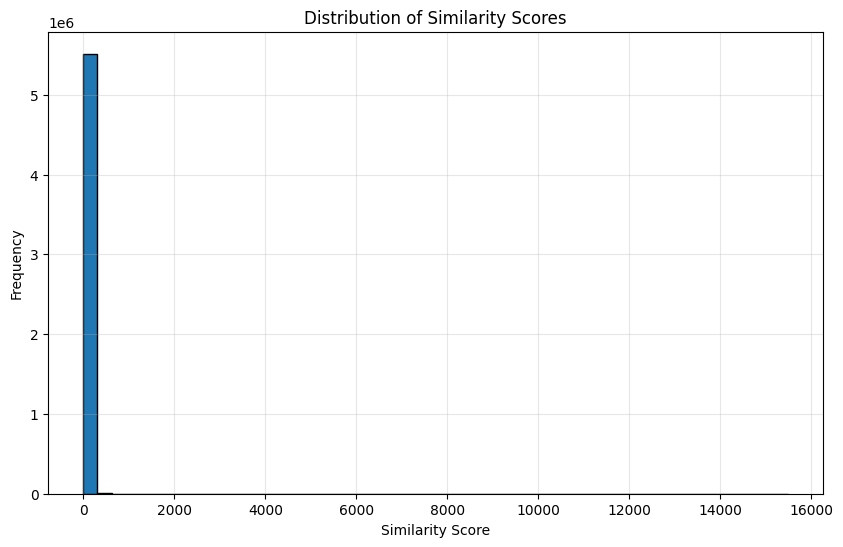

In [24]:
# Function to retrieve all similarity scores
def get_all_similarity_scores(conn):
    cursor = conn.cursor()
    cursor.execute('''SELECT user_id, similarity_vector FROM user_user_similarity''')
    all_scores = []
    user_count = 0
    empty_vectors = 0
    
    for user_id, sim_vector_blob in cursor.fetchall():
        user_count += 1
        if sim_vector_blob is None:
            empty_vectors += 1
            continue
        try:
            similarity_vector = pickle.loads(sim_vector_blob)
            indices, data = similarity_vector
            if len(data) == 0:
                empty_vectors += 1
                continue
            all_scores.extend(data)  # Add similarity scores to the list
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    
    print(f"Processed {user_count} users, {empty_vectors} had empty or null vectors.")
    return all_scores

# Get all similarity scores
similarity_scores = get_all_similarity_scores(conn)

# Close the connection
conn.close()

# Convert to numpy array for stats
scores_array = np.array(similarity_scores)

# Compute statistics
stats = {
    'Count': len(scores_array),
    'Mean': np.mean(scores_array),
    'Median': np.median(scores_array),
    'Std Dev': np.std(scores_array),
    'Min': np.min(scores_array),
    'Max': np.max(scores_array),
    '25th Percentile': np.percentile(scores_array, 25),
    '50th Percentile': np.percentile(scores_array, 50),
    '75th Percentile': np.percentile(scores_array, 75),
    '90th Percentile': np.percentile(scores_array, 90),
    '95th Percentile': np.percentile(scores_array, 95)
}

# Display statistics
stats_df = pd.DataFrame(stats, index=[0])
print("Similarity Score Statistics:")
display(stats_df)

# Optional: Plot histogram of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(scores_array, bins=50, edgecolor='black')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
# Tune similarity threshold for maximum retrieval accuracy
thresholds = [x for x in range(5, 80, 5)]
best_recall = 0
best_threshold = 0
best_metrics = None
best_confusion = None
best_background_stats = None


for threshold in thresholds:
    retrieval_recommendations = simulate_recommendations_usercf(test_data_grouped, user_mapping, user_to_cluster, similarity_threshold=threshold, conn=conn, k=300, num_users=1000)
    true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks = check_retrieval_recommendations(retrieval_recommendations, test_data, test_data_grouped)
    evaluation_metric, confusion_matrix, background_stats = compute_evaluation_metric(true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks)
    
    recall = evaluation_metric['Recall'].iloc[0]
    print(f"Threshold: {threshold}, Retrieval Recall: {recall}")
    print("Retrieval Evaluation Metrics")
    display(evaluation_metric)
    print("Retrieval Confusion Matrix")
    display(confusion_matrix)
    if recall > best_recall:
        best_recall = recall
        best_threshold = threshold
        best_metrics = evaluation_metric
        best_confusion = confusion_matrix
        best_background_stats = background_stats

print(f"Best Threshold: {best_threshold}, Retrieval Recall: {best_recall}")

Threshold: 5, Retrieval Recall: 0.2699
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5371,0.5595,0.2699,0.3641,0.301,0.0657


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,282,861,222,763


Threshold: 10, Retrieval Recall: 0.2679
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5367,0.5589,0.2679,0.3622,0.2991,0.0637


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,280,862,221,765


Threshold: 15, Retrieval Recall: 0.267
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5371,0.5602,0.267,0.3616,0.2982,0.0606


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,279,864,219,766


Threshold: 20, Retrieval Recall: 0.2603
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5357,0.5585,0.2603,0.3551,0.2914,0.0632


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,272,868,215,773


Threshold: 25, Retrieval Recall: 0.2507
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5376,0.5659,0.2507,0.3475,0.2821,0.0683


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,262,882,201,783


Threshold: 30, Retrieval Recall: 0.2392
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.539,0.5734,0.2392,0.3376,0.2708,0.0637


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,250,897,186,795


Threshold: 35, Retrieval Recall: 0.2239
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5343,0.5652,0.2239,0.3208,0.2547,0.0683


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,234,903,180,811


Threshold: 40, Retrieval Recall: 0.2144
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5338,0.5671,0.2144,0.3111,0.2448,0.075


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,224,912,171,821


Threshold: 45, Retrieval Recall: 0.2038
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5357,0.5772,0.2038,0.3013,0.2341,0.0901


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,213,927,156,832


Threshold: 50, Retrieval Recall: 0.2029
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5371,0.5824,0.2029,0.3009,0.2333,0.0894


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,212,931,152,833


Threshold: 55, Retrieval Recall: 0.1866
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5343,0.5804,0.1866,0.2824,0.2159,0.0888


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,195,942,141,850


Threshold: 60, Retrieval Recall: 0.1799
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5343,0.5839,0.1799,0.2751,0.2088,0.0822


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,188,949,134,857


Threshold: 65, Retrieval Recall: 0.1742
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5329,0.5815,0.1742,0.268,0.2025,0.0806


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,182,952,131,863


Threshold: 70, Retrieval Recall: 0.1636
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5324,0.5856,0.1636,0.2558,0.1912,0.083


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,171,962,121,874


Threshold: 75, Retrieval Recall: 0.1627
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5329,0.5882,0.1627,0.2549,0.1902,0.0828


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,170,964,119,875


Best Threshold: 5, Retrieval Recall: 0.2699


In [41]:
# get_top_k_similar_users_with_clusters2 is the only updated function
def get_top_k_similar_users_with_clusters2(user_id, user_mapping, user_to_cluster, similarity_threshold, k, conn):
    cursor = conn.cursor()
    cursor.execute('''SELECT similarity_vector FROM user_user_similarity WHERE user_id = ?''', (user_id,))
    result = cursor.fetchone()
    if result is None:
        similar_users = []
        threshold = similarity_threshold
    else:
        similarity_vector = pickle.loads(result[0])
        indices, data = similarity_vector
        idx_to_user = {v: k for k, v in user_mapping.items()}
        
        # Dynamic threshold
        threshold = similarity_threshold
        min_sim_users = k // 2
        while True:
            similar_users = [(idx_to_user.get(idx, "Unknown"), score) for idx, score in zip(indices, data) if score >= threshold]
            current_count = len([u for u, s in similar_users if u != "Unknown"])
            if current_count >= min_sim_users or threshold <= 5:
                break
            threshold -= 5
        similar_users = sorted(similar_users, key=lambda x: -x[1])[:k]

    current_count = len([u for u, s in similar_users if u != "Unknown"])
    if user_id in user_to_cluster and current_count < k:
        target_cluster = user_to_cluster[user_id]
        cluster_users = cluster_df[cluster_df['cluster'] == target_cluster]['user_id'].tolist()
        cluster_users = [u for u in cluster_users if u != user_id and u not in [su[0] for su in similar_users]]

        # Rank by overlap
        target_businesses = set(bid for bid, _ in get_user_businesses(user_id, conn))
        cluster_user_scores = [(u, len(target_businesses & set(bid for bid, _ in get_user_businesses(u, conn))))
                              for u in cluster_users if u in user_mapping]
        cluster_user_scores.sort(key=lambda x: -x[1])
        ranked_cluster_users = [u for u, _ in cluster_user_scores]

        if current_count == 0:
            similar_users = [(u, 0) for u in ranked_cluster_users[:k]]
        elif current_count < k:
            needed = k - current_count
            additional_users = [(u, 0) for u in ranked_cluster_users[:needed]]
            similar_users.extend(additional_users)

    return similar_users[:k]

# Predict user interests for recommendation
def predict_user_interests_usercf2(user_id, user_mapping, user_to_cluster, similarity_threshold, conn, k=300):
    similar_users = get_top_k_similar_users_with_clusters2(user_id, user_mapping, user_to_cluster, similarity_threshold, k, conn)
    recommended_businesses = {}
    for similar_user_id, _ in similar_users:
        if similar_user_id == "Unknown":
            continue
        similar_user_businesses = get_user_businesses(similar_user_id, conn)
        for business_id, score in similar_user_businesses:
            if business_id in recommended_businesses:
                recommended_businesses[business_id] += score
            else:
                recommended_businesses[business_id] = score
    recommended_businesses = sorted(recommended_businesses.items(), key=lambda x: -x[1])
    return recommended_businesses[:k]

# Simulate recommendations for test users
def simulate_recommendations_usercf2(test_data_grouped, user_mapping, user_to_cluster, similarity_threshold, conn, k=300, num_users=1000):
    recommendations = {}
    for i, user_id in enumerate(test_data_grouped['user_id']):
        if i >= num_users:
            break
        recommendation = predict_user_interests_usercf2(user_id, user_mapping, user_to_cluster, similarity_threshold, conn, k)
        business_ids, scores = zip(*recommendation) if recommendation else ([], [])
        recommendations[user_id] = (list(business_ids), list(scores))
    return recommendations

In [42]:
# Tune similarity threshold for maximum retrieval accuracy
thresholds = [x for x in range(5, 50, 5)]
best_recall = 0
best_threshold = 0
best_metrics = None
best_confusion = None
best_background_stats = None

for threshold in thresholds:
    retrieval_recommendations = simulate_recommendations_usercf(test_data_grouped, user_mapping, user_to_cluster, similarity_threshold=threshold, conn=conn, k=300, num_users=1000)
    true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks = check_retrieval_recommendations(retrieval_recommendations, test_data, test_data_grouped)
    evaluation_metric, confusion_matrix, background_stats = compute_evaluation_metric(true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks)
    
    recall = evaluation_metric['Recall'].iloc[0]
    print(f"Threshold: {threshold}, Retrieval Recall: {recall}")
    print("Retrieval Evaluation Metrics")
    display(evaluation_metric)
    print("Retrieval Confusion Matrix")
    display(confusion_matrix)
#     if recall > best_recall:
#         best_recall = recall
#         best_threshold = threshold
#         best_metrics = evaluation_metric
#         best_confusion = confusion_matrix
#         best_background_stats = background_stats

# print(f"Best Threshold: {best_threshold}, Retrieval Recall: {best_recall}")

Threshold: 5, Retrieval Recall: 0.2699
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5371,0.5595,0.2699,0.3641,0.301,0.0657


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,282,861,222,763


Threshold: 10, Retrieval Recall: 0.2679
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5367,0.5589,0.2679,0.3622,0.2991,0.0637


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,280,862,221,765


Threshold: 15, Retrieval Recall: 0.267
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5371,0.5602,0.267,0.3616,0.2982,0.0606


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,279,864,219,766


Threshold: 20, Retrieval Recall: 0.2603
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5357,0.5585,0.2603,0.3551,0.2914,0.0632


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,272,868,215,773


Threshold: 25, Retrieval Recall: 0.2507
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5376,0.5659,0.2507,0.3475,0.2821,0.0683


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,262,882,201,783


Threshold: 30, Retrieval Recall: 0.2392
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.539,0.5734,0.2392,0.3376,0.2708,0.0637


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,250,897,186,795


Threshold: 35, Retrieval Recall: 0.2239
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5343,0.5652,0.2239,0.3208,0.2547,0.0683


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,234,903,180,811


Threshold: 40, Retrieval Recall: 0.2144
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5338,0.5671,0.2144,0.3111,0.2448,0.075


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,224,912,171,821


Threshold: 45, Retrieval Recall: 0.2038
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5357,0.5772,0.2038,0.3013,0.2341,0.0901


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,213,927,156,832


In [51]:
def get_top_k_similar_users_with_threshold(user_id, user_mapping, user_to_cluster, similarity_threshold, k, conn):
    cursor = conn.cursor()
    cursor.execute('''SELECT similarity_vector FROM user_user_similarity WHERE user_id = ?''', (user_id,))
    result = cursor.fetchone()
    
    idx_to_user = {v: k for k, v in user_mapping.items()}
    if result is None:
        similar_users = []
    else:
        similarity_vector = pickle.loads(result[0])
        indices, data = similarity_vector
        # Filter by threshold
        similar_users = [(idx_to_user.get(idx, "Unknown"), score) for idx, score in zip(indices, data) if score >= similarity_threshold]
        similar_users = sorted(similar_users, key=lambda x: -x[1])  # Sort by similarity
    
    valid_sim_users = [(u, s) for u, s in similar_users if u != "Unknown"]
    num_similar = len(valid_sim_users)
    
    if num_similar >= k:
        # Take top k from similarity vector
        return valid_sim_users[:k]
    else:
        # Supplement with cluster users
        if user_id not in user_to_cluster:
            return valid_sim_users[:k]  # Return what we have if no cluster data
        target_cluster = user_to_cluster[user_id]
        cluster_users = cluster_df[cluster_df['cluster'] == target_cluster]['user_id'].tolist()
        cluster_users = [u for u in cluster_users if u != user_id and u not in [su[0] for su in valid_sim_users]]
        
        # Add cluster users to reach k
        needed = k - num_similar
        additional_users = [(u, 0) for u in cluster_users[:needed] if u in user_mapping]
        return valid_sim_users + additional_users[:k - num_similar]  # Ensure exactly k
    
    # Predict user interests for recommendation
def predict_user_interests_usercf4(user_id, user_mapping, user_to_cluster, similarity_threshold, conn, k=300):
    similar_users = get_top_k_similar_users_with_threshold(user_id, user_mapping, user_to_cluster, similarity_threshold, k, conn)
    recommended_businesses = {}
    for similar_user_id, _ in similar_users:
        if similar_user_id == "Unknown":
            continue
        similar_user_businesses = get_user_businesses(similar_user_id, conn)
        for business_id, score in similar_user_businesses:
            if business_id in recommended_businesses:
                recommended_businesses[business_id] += score
            else:
                recommended_businesses[business_id] = score
    recommended_businesses = sorted(recommended_businesses.items(), key=lambda x: -x[1])
    return recommended_businesses[:k]

# Simulate recommendations for test users
def simulate_recommendations_usercf4(test_data_grouped, user_mapping, user_to_cluster, similarity_threshold, conn, k=300, num_users=1000):
    recommendations = {}
    for i, user_id in enumerate(test_data_grouped['user_id']):
        if i >= num_users:
            break
        recommendation = predict_user_interests_usercf4(user_id, user_mapping, user_to_cluster, similarity_threshold, conn, k)
        business_ids, scores = zip(*recommendation) if recommendation else ([], [])
        recommendations[user_id] = (list(business_ids), list(scores))
    return recommendations

In [52]:
# Tune similarity threshold for maximum retrieval accuracy
thresholds = [x for x in range(5, 50, 5)]
best_recall = 0
best_threshold = 0
best_metrics = None
best_confusion = None
best_background_stats = None

for threshold in thresholds:
    retrieval_recommendations = simulate_recommendations_usercf4(test_data_grouped, user_mapping, user_to_cluster, similarity_threshold=threshold, conn=conn, k=300, num_users=1000)
    true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks = check_retrieval_recommendations(retrieval_recommendations, test_data, test_data_grouped)
    evaluation_metric, confusion_matrix, background_stats = compute_evaluation_metric(true_positive, true_negative, false_positive, false_negative, total, total_positive, ranks)
    
    recall = evaluation_metric['Recall'].iloc[0]
    print(f"Threshold: {threshold}, Retrieval Recall: {recall}")
    print("Retrieval Evaluation Metrics")
    display(evaluation_metric)
    print("Retrieval Confusion Matrix")
    display(confusion_matrix)

Threshold: 5, Retrieval Recall: 0.2699
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5371,0.5595,0.2699,0.3641,0.301,0.0657


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,282,861,222,763


Threshold: 10, Retrieval Recall: 0.2679
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5367,0.5589,0.2679,0.3622,0.2991,0.0637


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,280,862,221,765


Threshold: 15, Retrieval Recall: 0.267
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5371,0.5602,0.267,0.3616,0.2982,0.0606


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,279,864,219,766


Threshold: 20, Retrieval Recall: 0.2603
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5357,0.5585,0.2603,0.3551,0.2914,0.0632


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,272,868,215,773


Threshold: 25, Retrieval Recall: 0.2507
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5376,0.5659,0.2507,0.3475,0.2821,0.0683


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,262,882,201,783


Threshold: 30, Retrieval Recall: 0.2392
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.539,0.5734,0.2392,0.3376,0.2708,0.0637


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,250,897,186,795


Threshold: 35, Retrieval Recall: 0.2239
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5343,0.5652,0.2239,0.3208,0.2547,0.0683


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,234,903,180,811


Threshold: 40, Retrieval Recall: 0.2144
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5338,0.5671,0.2144,0.3111,0.2448,0.075


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,224,912,171,821


Threshold: 45, Retrieval Recall: 0.2038
Retrieval Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Mean Reciprocal Rank
0,0.5357,0.5772,0.2038,0.3013,0.2341,0.0901


Retrieval Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,213,927,156,832


In [53]:
def analyze_similar_users_distribution(conn, user_mapping, k=300, thresholds=[5, 15, 25, 45, 58]):
    cursor = conn.cursor()
    cursor.execute('''SELECT user_id, similarity_vector FROM user_user_similarity''')
    results = cursor.fetchall()
    
    idx_to_user = {v: k for k, v in user_mapping.items()}
    total_users = len(results)
    
    # Store counts for each threshold
    threshold_counts = {thresh: {'less_than_k': 0, 'at_least_k': 0} for thresh in thresholds}
    no_threshold_counts = {'less_than_k': 0, 'at_least_k': 0}
    
    for user_id, sim_vector_blob in results:
        if sim_vector_blob is None:
            no_threshold_counts['less_than_k'] += 1
            for thresh in thresholds:
                threshold_counts[thresh]['less_than_k'] += 1
            continue
        
        similarity_vector = pickle.loads(sim_vector_blob)
        indices, data = similarity_vector
        
        # No threshold case
        sim_users_no_thresh = [idx for idx in indices if idx_to_user.get(idx, "Unknown") != "Unknown"]
        if len(sim_users_no_thresh) < k:
            no_threshold_counts['less_than_k'] += 1
        else:
            no_threshold_counts['at_least_k'] += 1
        
        # With threshold cases
        for thresh in thresholds:
            sim_users_with_thresh = [idx for idx, score in zip(indices, data) 
                                   if score >= thresh and idx_to_user.get(idx, "Unknown") != "Unknown"]
            if len(sim_users_with_thresh) < k:
                threshold_counts[thresh]['less_than_k'] += 1
            else:
                threshold_counts[thresh]['at_least_k'] += 1
    
    # Print summary
    print(f"k: {k}")
    print(f"No Threshold - Users with < {k}: {no_threshold_counts['less_than_k']} ({no_threshold_counts['less_than_k']/total_users*100:.2f}%)")
    print(f"No Threshold - Users with >= {k}: {no_threshold_counts['at_least_k']} ({no_threshold_counts['at_least_k']/total_users*100:.2f}%)")
    for thresh in thresholds:
        less_k = threshold_counts[thresh]['less_than_k']
        at_least_k = threshold_counts[thresh]['at_least_k']
        print(f"Threshold {thresh} - Users with < {k}: {less_k} ({less_k/total_users*100:.2f}%)")
        print(f"Threshold {thresh} - Users with >= {k}: {at_least_k} ({at_least_k/total_users*100:.2f}%)")
    
    # Prepare data for plotting
    thresholds_plot = [0] + thresholds  # Include 0 for no-threshold case
    less_than_k_counts = [no_threshold_counts['less_than_k']] + [threshold_counts[thresh]['less_than_k'] for thresh in thresholds]
    less_than_k_percent = [count / total_users * 100 for count in less_than_k_counts]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds_plot, less_than_k_counts, marker='o', label=f'Users with < {k} similar users')
    plt.xlabel('Similarity Threshold')
    plt.ylabel('Number of Users')
    plt.title(f'Number of Users with Fewer than {k} Similar Users vs. Threshold')
    plt.grid(True)
    plt.legend()
    
    # Add secondary y-axis for percentage
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.plot(thresholds_plot, less_than_k_percent, color='orange', marker='s', label='Percentage (%)')
    ax2.set_ylabel('Percentage of Total Users (%)')
    ax2.legend(loc='upper left')
    
    plt.show()

k: 300
No Threshold - Users with < 300: 162086 (100.00%)
No Threshold - Users with >= 300: 0 (0.00%)
Threshold 5 - Users with < 300: 162086 (100.00%)
Threshold 5 - Users with >= 300: 0 (0.00%)
Threshold 10 - Users with < 300: 162086 (100.00%)
Threshold 10 - Users with >= 300: 0 (0.00%)
Threshold 15 - Users with < 300: 162086 (100.00%)
Threshold 15 - Users with >= 300: 0 (0.00%)
Threshold 20 - Users with < 300: 162086 (100.00%)
Threshold 20 - Users with >= 300: 0 (0.00%)
Threshold 25 - Users with < 300: 162086 (100.00%)
Threshold 25 - Users with >= 300: 0 (0.00%)
Threshold 30 - Users with < 300: 162086 (100.00%)
Threshold 30 - Users with >= 300: 0 (0.00%)
Threshold 35 - Users with < 300: 162086 (100.00%)
Threshold 35 - Users with >= 300: 0 (0.00%)
Threshold 40 - Users with < 300: 162086 (100.00%)
Threshold 40 - Users with >= 300: 0 (0.00%)
Threshold 45 - Users with < 300: 162086 (100.00%)
Threshold 45 - Users with >= 300: 0 (0.00%)


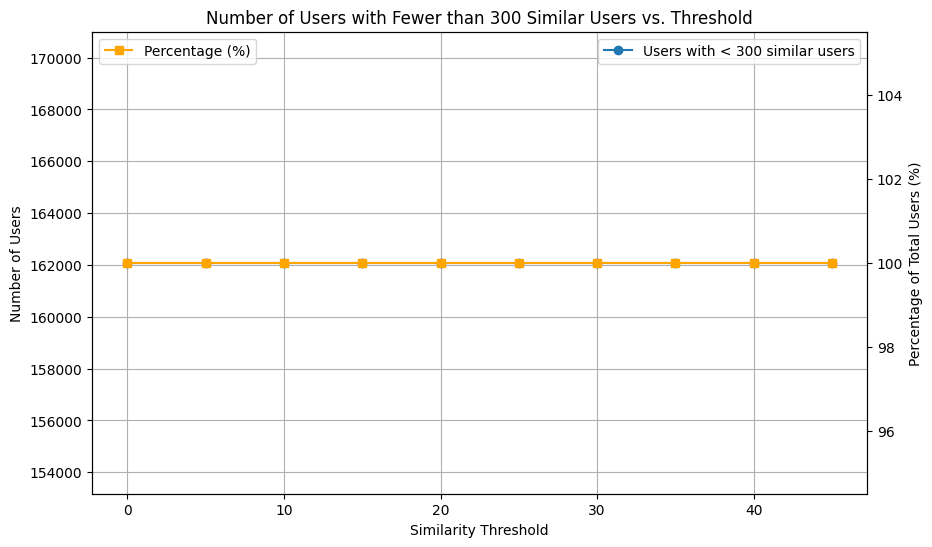

In [54]:
analyze_similar_users_distribution(conn, user_mapping, k=300, thresholds=thresholds)

# Prediction

In [13]:
# Predict rating for a specific business (mirroring ItemCF)
def get_business_interest_usercf(user_id, business_id, user_mapping, user_to_cluster, conn, k=100, similarity_threshold=best_threshold):
    user_businesses = get_user_businesses(user_id, conn)
    if not user_businesses:
        return 0  # No interactions
    similar_users = get_top_k_similar_users_with_clusters(user_id, user_mapping, user_to_cluster, k, conn, similarity_threshold)
    if not similar_users:
        return -1  # No similar users
    weighted_sum = 0.0
    similarity_sum = 0.0
    for similar_user_id, similarity in similar_users:
        if similar_user_id == "Unknown":
            continue
        cursor = conn.cursor()
        cursor.execute('SELECT stars_review FROM user_item_index WHERE user_id = ? AND business_id = ?', 
                       (similar_user_id, business_id))
        result = cursor.fetchone()
        if result:
            rating = result[0]
            weighted_sum += similarity * rating
            similarity_sum += similarity
    if similarity_sum == 0:
        return -1  # No ratings from similar users
    return weighted_sum / similarity_sum

In [14]:
# Predict ratings for test pairs (identical to ItemCF structure)
def predict_recommendations_usercf(test_data, test_data_grouped, user_mapping, user_to_cluster, conn, pos=4, k=100, similarity_threshold=best_threshold):
    predicted_labels = []
    actual_labels = []
    unrated_count = 0
    positive_count = 0
    negative_count = 0
    null_count = 0
    k_users = min(1000, len(test_data_grouped))
    test_data_dict = {
        (row['user_id'], row['business_id']): row['stars_review']
        for _, row in test_data.iterrows()
    }
    for i in range(k_users):
        user_id = test_data_grouped['user_id'].iloc[i]
        business_ids = test_data_grouped['business_id'].iloc[i]
        for business_id in business_ids:
            predicted_rating = get_business_interest_usercf(user_id, business_id, user_mapping, user_to_cluster, conn, k, similarity_threshold)
            actual_rating = test_data_dict.get((user_id, business_id), None)
            if actual_rating is None:
                null_count += 1
            else:
                if actual_rating >= pos:
                    positive_count += 1
                else:
                    negative_count += 1
            if actual_rating is None or predicted_rating == -1:
                unrated_count += 1
                continue
            predicted_labels.append(predicted_rating >= pos)
            actual_labels.append(actual_rating >= pos)
    predicted_labels = np.array(predicted_labels, dtype=np.int8)
    actual_labels = np.array(actual_labels, dtype=np.int8)
    return predicted_labels, actual_labels, positive_count, negative_count, null_count, unrated_count

In [15]:
# Evaluate prediction with initial threshold
predicted_labels, actual_labels, positive_count, negative_count, null_count, unrated_count = predict_recommendations_usercf(test_data, test_data_grouped, user_mapping, user_to_cluster, conn, pos=4, k=100, similarity_threshold=0.1)
prediction_lst = [positive_count, negative_count, unrated_count]
evaluation_metric, confusion_matrix, background_stats = compute_prediction_evaluation(actual_labels, predicted_labels, prediction_lst, beta=2)

In [16]:
print("Testing Data Statistics")
display(background_stats)
if 'Mean Reciprocal Rank' in evaluation_metric.columns:
    evaluation_metric.drop(columns=['Mean Reciprocal Rank'], inplace=True)
print("Prediction Evaluation Metrics")
display(evaluation_metric)
print("Prediction Confusion Matrix")
display(confusion_matrix)

Testing Data Statistics


,Total Positive,Total Negative,Total,Ratio
0,1043,1085,2128,0.490132


Prediction Evaluation Metrics


,Accuracy,Precision,Recall,F1 Score,F-beta Score,Unrated Count
0,0.569,0.5722,0.395019,0.467381,0.421097,0.397086


Prediction Confusion Matrix


,True Positive,True Negative,False Positive,False Negative
0,412,318,308,245
